# ASAXS data reduction

some script description

## Libraries

In [1]:
import pandas as pd
import os
import csv
import time

import numpy as np
from scipy import optimize
import scipy.integrate as integrate
import scipy.constants as con
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap

import fabio
import pyFAI
from pyFAI.detectors import Pilatus1M

## Fuctions

In [2]:
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
          
         'alpha': ((0.0, 0.0, 0.0),
                   (1.0, 0.7, 0.7))
         }
red_alpha = LinearSegmentedColormap('red_alpha', cdict)
plt.register_cmap(cmap=red_alpha)

## Read the basic data

In [55]:
# give the directory
data_dir = 'C:\\Users\\eikeg\\Documents\\Science\\qe05_ESRF\\3th-reaction'
# name if data file ontaining all nessesary information
metaFileName = '3th-reaction_ASCII_out_prepared.txt'
pathTo_ReferenceFile = 'files\GC-Calibration_Final\GC-K_90um-new2015.dat'

# For the azimuthal integration result
bin_number = 100 #how many data points are generated in 1D curves
pixelsize = 172e-6 #m
scale = 1  # upscaling of poisson error for visibility

# Write the corrected scattering images? A lot of export data!
write_the_images = False # only if True images are written to thetarget directory

#read the meta file
path_to_metaFile = data_dir + os.sep + metaFileName
metaFrame = pd.read_csv(path_to_metaFile, sep='\t',index_col=0)

# Define divice identifiers
sampleName = 'SampleName'
dataFileName = 'fileName'
dataFilePath = 'filePath'
monitorDiode = 'Monitor'
monitorDeviation = 'DiodeDiviation'
transmissionDiode = 'Photo'
transmissionDeviation = 'DiodeDiviation'
acquisitionTime = 'AcqTime'
sampleThickness = 'SampleThickness'
sampleName = 'SampleName'
xray_energy = 'Energy'
maskFileName = 'MaskFile'
BackGround_SubtractionFactor = 'BackGround_SubtractionFactor'
x_Center_String = 'x_Center' # in pixel
y_Center_String = 'y_Center' # in pixel
sampleToDetectorDistance = 'SampleToDet_Distance' # in meter

[]

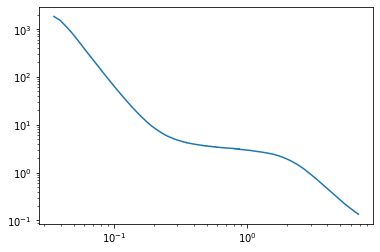

In [56]:
refData = np.genfromtxt(pathTo_ReferenceFile, delimiter=',',comments='#')
ref0_q = np.empty(0)
ref0_I = np.empty(0)
ref0_e = np.empty(0)
for i in range(refData.shape[0]):
    ref0_q = np.append(ref0_q,refData[i][0])
    ref0_I = np.append(ref0_I,refData[i][1])
    ref0_e = np.append(ref0_e,refData[i][2])
fig, ax = plt.subplots()
ax.plot(ref0_q, ref0_I)
ax.loglog()

In [57]:
metaFrame
metaFrame['fileName'][1].split('_')[-1][0:-4]

'0001'

## Data Handling

  File "<ipython-input-60-601e9f473ace>", line 155, in <module>
    detector=Pilatus1M(), wavelength=wavelength)


Directory  C:\Users\eikeg\Documents\Science\qe05_ESRF\3th-reaction\Corrected_1D  already exists
Directory  C:\Users\eikeg\Documents\Science\qe05_ESRF\3th-reaction\Corrected_2D  already exists
x_Center is 497.663 Reference is: exsitu_powder_SAXS_0001.edf | Empty is: exsitu_powder_SAXS_0000.edf
Reference Normalization between: 0.1752197382058044 nm^-1 and  0.8367748017708925 nm^-1
Index for Reference file: 35 with 0.17363 nm^-1 to 231 with 0.83657 nm^-1
Index for Experimental Reference data: 2 with 0.17036268000697413 nm^-1 to 18 with 0.8323851672395495 nm^-1
known 2.7876954885 experimental 0.0030462033923049875 factor 915.1376745039402


C:\Users\eikeg\Anaconda3\lib\site-packages\ipykernel_launcher.py:224: RuntimeWarning: invalid value encountered in true_divide


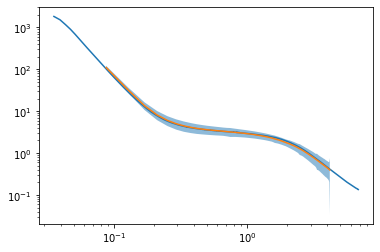

In [60]:
usedBackGr_index = 'False'
usedReference_index = 'False'
x_Center_old = 'False'
y_Center_old = 'False'
energy_old = 'False'
stDetDist_old = 'False'
maskFile_old = 'False'
correctionFrame = pd.DataFrame()

#Create Output Directories
pathSave_to1D = data_dir + os.sep + 'Corrected_1D'
pathSave_to2D = data_dir + os.sep + 'Corrected_2D'

if not os.path.exists(pathSave_to1D):
    os.mkdir(pathSave_to1D)
    print("Directory " , pathSave_to1D ,  " Created ")
else:    
    print("Directory " , pathSave_to1D ,  " already exists")

if not os.path.exists(pathSave_to2D):
    os.mkdir(pathSave_to2D)
    print("Directory " , pathSave_to2D ,  " Created ")
else:    
    print("Directory " , pathSave_to2D ,  " already exists")

    
    
for element in metaFrame.index:
    # read the image
    tiffName = metaFrame[dataFileName][element] #.split('/')[-1]
    tiffPath = metaFrame[dataFilePath][element]
    image_object = fabio.open(tiffPath)
    image = image_object.data
    
    # read values
    name = metaFrame[sampleName][element]
    monitorI = metaFrame[monitorDiode][element]
    transmI = metaFrame[transmissionDiode][element]
    monitorI_dev = metaFrame[monitorDeviation][element]
    transmI_dev = metaFrame[transmissionDeviation][element]
    acqTime = metaFrame[acquisitionTime][element]
    thickness = metaFrame[sampleThickness][element]
    energy = metaFrame[xray_energy][element]
    tifNum = tiffName.split('_')[-1][0:-4]
    BackGr_SubstF = metaFrame[BackGround_SubtractionFactor][element]
    
    empty_monitorI = metaFrame[monitorDiode][metaFrame['Empty_Index'][element]]
    empty_transmI = metaFrame[transmissionDiode][metaFrame['Empty_Index'][element]]
    
    # calculate transmission
    image_transmission = (transmI/monitorI)/(empty_transmI/empty_monitorI)
    image_transmission_deviation = image_transmission * (monitorI_dev/monitorI + transmI_dev/transmI)
    #print(tiffName,'measured',acqTime,'sec with transmission:' , image_transmission, '+/-',image_transmission_deviation)
    
    # normalizing image
    image = image / monitorI / acqTime / image_transmission
    
    # loead the image background file
    if int(metaFrame['Background_Index'][element]) == usedBackGr_index:
        #print('stay')
        pass
    else:
        # read the BackGround image
        tiffName_BackGr = tiffPath_BackGr = metaFrame[dataFileName][metaFrame['Background_Index'][element]]
        tiffPath_BackGr = metaFrame[dataFilePath][metaFrame['Background_Index'][element]]
        
        image_object_BackGr = fabio.open(tiffPath_BackGr)
        image_BackGr = image_object_BackGr.data
        usedBackGr_index = int(metaFrame['Background_Index'][element])
        
        # read BackGround values
        monitorI_BG = metaFrame[monitorDiode][usedBackGr_index]
        transmI_BG = metaFrame[transmissionDiode][usedBackGr_index]
        monitorI_BG_dev = metaFrame[monitorDeviation][usedBackGr_index]
        transmI_BG_dev = metaFrame[transmissionDeviation][usedBackGr_index]
        acqTime_BG = metaFrame[acquisitionTime][usedBackGr_index]
        empty_monitorI_BG = metaFrame[monitorDiode][metaFrame['Empty_Index'][usedBackGr_index]]
        empty_transmI_BG = metaFrame[transmissionDiode][metaFrame['Empty_Index'][usedBackGr_index]]
        
        # calculate BackGround transmission
        image_transmission_BG = (transmI_BG/monitorI_BG)/(empty_transmI_BG/empty_monitorI_BG)
        image_transmission_BG_deviation = image_transmission_BG * (monitorI_BG_dev/monitorI_BG + transmI_BG_dev/transmI_BG)
        
        # normalizing BackGround image
        image_BackGr = image_BackGr / monitorI_BG / acqTime_BG / image_transmission_BG
        #print(usedBackGr_index,'=',image_transmission_BG,'+/-',image_transmission_BG_deviation)
    
    # Subtract the scattering Background
    image = image - image_BackGr*BackGr_SubstF
    image = image/thickness
    
    # loead the image Reference file
    if int(metaFrame['Reference_Index'][element]) == usedReference_index:
        #print('stay')
        pass
    else:
        usedReference_index = int(metaFrame['Reference_Index'][element])
        # read the Reference image
        tiffName_Ref = metaFrame[dataFileName][usedReference_index]
        tiffPath_Ref = metaFrame[dataFilePath][usedReference_index]
        image_object_Ref = fabio.open(tiffPath_Ref)
        image_Ref = image_object_Ref.data
        
        tiffName_Empty = metaFrame[dataFileName][metaFrame['Empty_Index'][usedReference_index]]
        tiffPath_Empty = metaFrame[dataFilePath][metaFrame['Empty_Index'][usedReference_index]]
        image_object_Empty = fabio.open(tiffPath_Empty)
        image_Empty = image_object_Empty.data
        
        
        # read Reference values
        monitorI_Ref = metaFrame[monitorDiode][usedReference_index]
        transmI_Ref = metaFrame[transmissionDiode][usedReference_index]
        monitorI_Ref_dev = metaFrame[monitorDeviation][usedReference_index]
        transmI_Ref_dev = metaFrame[transmissionDeviation][usedReference_index]
        acqTime_Ref = metaFrame[acquisitionTime][usedReference_index]
        thickness_Ref = metaFrame[sampleThickness][usedReference_index]
        
        energy = metaFrame[xray_energy][usedReference_index]
        wavelength = con.h * con.c / con.e / energy  # m
        x_Center = metaFrame[x_Center_String][usedReference_index] #Reference
        y_Center = metaFrame[y_Center_String][usedReference_index] #Reference
        stDetDist = metaFrame[sampleToDetectorDistance][usedReference_index]
        maskFile = metaFrame[maskFileName][usedReference_index]
        
        
        empty_monitorI_Ref = metaFrame[monitorDiode][metaFrame['Empty_Index'][usedReference_index]]
        empty_transmI_Ref = metaFrame[transmissionDiode][metaFrame['Empty_Index'][usedReference_index]]
        empty_acqTime = metaFrame[acquisitionTime][metaFrame['Empty_Index'][usedReference_index]]
        
        # calculate Reference and Reference-BackGround transmission
        image_transmission_Ref = (transmI_Ref/monitorI_Ref)/(empty_transmI_Ref/empty_monitorI_Ref)
        image_transmission_Ref_deviation = image_transmission_Ref * (monitorI_Ref_dev/monitorI_Ref + transmI_Ref_dev/transmI)
        
        image_transmission_Empty = (empty_transmI_Ref/empty_monitorI_Ref)/(empty_transmI_Ref/empty_monitorI_Ref)
        
        
        # normalizing Reference image
        image_Ref = image_Ref / monitorI_Ref / acqTime_Ref / image_transmission_Ref
        image_Empty = image_Empty / empty_monitorI_Ref / empty_acqTime / image_transmission_Empty
        image_Ref = image_Ref - image_Empty
        image_Ref = image_Ref/thickness_Ref
        
        print('x_Center is',x_Center,'Reference is:',tiffName_Ref,'| Empty is:', tiffName_Empty)
        
        if x_Center == x_Center_old and y_Center == y_Center_old and energy == energy_old and stDetDist == stDetDist_old and maskFile == maskFile_old:
            pass
        else:
            x_Center_old = x_Center
            y_Center_old = y_Center
            energy_old = energy
            stDetDist_old = stDetDist
            maskFile_old = maskFile
            
            ai = pyFAI.AzimuthalIntegrator(dist=stDetDist, poni1=y_Center*pixelsize, poni2=x_Center *pixelsize,
                                   detector=Pilatus1M(), wavelength=wavelength)
            # adress the mask
            ai_mask_path = data_dir + os.sep + maskFile
            ai_mask_object = fabio.open(ai_mask_path)
            ai_mask = ai_mask_object.data
        
        #Do the azimutal integration of the Reference file
        ref_q, ref_I, ref_e = ai.integrate1d(image_Ref, bin_number, error_model='poisson', mask=ai_mask)
        
        # find integration limits for the Reference data
        q_Limit_min = np.array((ref0_q.min(),ref_q.min())).max()
        q_Limit_max = np.array((ref0_q.max(),ref_q.max())).min()
        q_normLimit_min = 2 * q_Limit_min
        q_normLimit_max = q_Limit_max - 0.8*q_Limit_max
        # find the index close to the limit
        ref0_IndexMin = min(range(ref0_q.size), key=lambda i: abs(ref0_q[i]-q_normLimit_min))
        ref0_IndexMax = min(range(ref0_q.size), key=lambda i: abs(ref0_q[i]-q_normLimit_max))
        ref_IndexMin = min(range(ref_q.size), key=lambda i: abs(ref_q[i]-q_normLimit_min))
        ref_IndexMax = min(range(ref_q.size), key=lambda i: abs(ref_q[i]-q_normLimit_max))
        
        print('Reference Normalization between:',q_normLimit_min,'nm^-1 and ',q_normLimit_max,'nm^-1')
        print('Index for Reference file:',ref0_IndexMin,'with',ref0_q[ref0_IndexMin],'nm^-1 to',ref0_IndexMax,'with',ref0_q[ref0_IndexMax],'nm^-1')
        print('Index for Experimental Reference data:',ref_IndexMin,'with',ref_q[ref_IndexMin],'nm^-1 to',ref_IndexMax,'with',ref_q[ref_IndexMax],'nm^-1')
        # Get the normalization/calibration factor
        int_Reference0 = integrate.trapz(y=ref0_I[ref0_IndexMin:ref0_IndexMax] ,x=ref0_q[ref0_IndexMin:ref0_IndexMax], axis=- 1)
        int_Reference = integrate.trapz(y=ref_I[ref_IndexMin:ref_IndexMax] ,x=ref_q[ref_IndexMin:ref_IndexMax], axis=- 1)
        calibrationFactor = int_Reference0/int_Reference
        print('known',int_Reference0,'experimental',int_Reference,'factor',calibrationFactor)
        # use calibration Factor on experimental reference data
        ref_I = ref_I * calibrationFactor
        ref_e = ref_e * calibrationFactor
        
        # plot measured and known Reference data
        fig, ax = plt.subplots()
        ax.plot(ref0_q, ref0_I)
        ax.fill_between(ref_q, ref_I + scale * ref_e, ref_I - scale * ref_e, alpha=0.5)
        ax.plot(ref_q, ref_I)
        ax.loglog()

    
    # Do the azimutal integration of the Reference file
    energy = metaFrame[xray_energy][element]
    wavelength = con.h * con.c / con.e / energy  # m
    x_Center = metaFrame[x_Center_String][element]
    y_Center = metaFrame[y_Center_String][element]
    stDetDist = metaFrame[sampleToDetectorDistance][element]
    maskFile = metaFrame[maskFileName][element]
    
    if x_Center == x_Center_old and y_Center == y_Center_old and energy == energy_old and stDetDist == stDetDist_old and maskFile == maskFile_old:
        pass
    else:
        x_Center_old = x_Center
        y_Center_old = y_Center
        energy_old = energy
        stDetDist_old = stDetDist
        maskFile_old = maskFile
    
        ai = pyFAI.AzimuthalIntegrator(dist=stDetDist, poni1=y_Center*pixelsize, poni2=x_Center *pixelsize,
                               detector=Pilatus1M(), wavelength=wavelength)
        # adress the mask
        ai_mask_path = data_dir + os.sep + maskFile
        ai_mask_object = fabio.open(ai_mask_path)
        ai_mask = ai_mask_object.data
    
    # usage of integrate 1d method
    image = image * calibrationFactor
    q, I, e = ai.integrate1d(image, bin_number, error_model='poisson', mask=ai_mask)
    #I = I * calibrationFactor
    #e = e * calibrationFactor
    e = I * (e/I + image_transmission_deviation/image_transmission)
    
    #plotTitle_str = str(name)+' at '+str(round(energy))+' eV'
    #fig, ax = plt.subplots()
    #ax.fill_between(q, I + scale * e, I - scale * e, alpha=0.5)
    #ax.plot(q, I)
    #plt.title(plotTitle_str, fontdict=None, loc='center', pad=None)
    #ax.loglog()
    
    correctionFrame = correctionFrame.append({'SampleName_Reduction':name,'Transm':image_transmission, 'TransmDev':image_transmission_deviation,'BackGrTransm':image_transmission_BG,'ReferenceTransm':image_transmission_Ref,'AbsCalibrationFactor':calibrationFactor},ignore_index=True)       
    #fig, ax = plt.subplots()
    #ax.imshow(image, norm=LogNorm())
  
    # Save Numpy array to csv with header    
    save_file_name = pathSave_to1D+os.sep+str(name)+'_'+str(round(energy))+'_eV_Edf_'+str(tifNum)+'_Norm.dat'
    file_header = 'Normalized\t'+str(name)+'\t'+str(round(energy))+' eV\n'+'q\tI\tPoisson error\nnm-1\tcm-1\tcm-1'
    np.savetxt(save_file_name, np.column_stack((q, I, e)), delimiter='\t', header=file_header)
    
    # Save image files
    if write_the_images == True: 
        image_object.data = image
        save_image_name = pathSave_to2D+os.sep+str(name)+'_'+str(round(energy))+'_eV_Edf_'+str(tifNum)+'_Norm.edf'
        image_object.write(save_image_name)
    else:
        pass
    
# Save Pandas Frame to csv with header    
outputFrame = metaFrame.join(correctionFrame)
save_outPut_name = data_dir+os.sep+'DateCorrection_logg'+'.txt'
outputFrame.to_csv(save_outPut_name, sep='\t')   

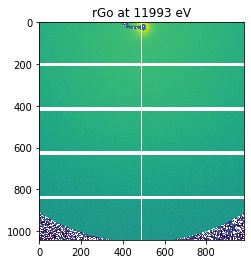

In [59]:
fig, ax = plt.subplots()
plotTitle_str = str(name)+' at '+str(round(energy))+' eV'
plt.title(plotTitle_str, fontdict=None, loc='center', pad=None)
ax.imshow(image_Ref, norm=LogNorm())

In [51]:
outputFrame

,fileName,filePath,time,sampleX,sampleY,FrameTime,Monitor,Photo,SampleName,SampleThickness,...,y_Center,SampleToDet_Distance,DiodeDiviation,AcqTime,AbsCalibrationFactor,BackGrTransm,ReferenceTransm,SampleName_Reduction,Transm,TransmDev
0,3th-reaction_UV-light_SAXS_0000.edf,C:\Users\eikeg\Documents\Science\qe05_ESRF\3th...,Sat May 6 22:04:14 2017,0,-14.9825,14.0000,3623316.0,101739.0,3thR_0,0.100000,...,25.23,2.54696,100,1,894.30582,0.417666,0.979413,3thR_0,0.278942,0.000282
1,3th-reaction_UV-light_SAXS_0001.edf,C:\Users\eikeg\Documents\Science\qe05_ESRF\3th...,Sat May 6 22:04:29 2017,0,-14.9825,29.0000,3620284.0,104048.0,3thR_1,0.100000,...,25.23,2.54696,100,1,894.30582,0.417666,0.979413,3thR_1,0.285512,0.000282
2,3th-reaction_UV-light_SAXS_0002.edf,C:\Users\eikeg\Documents\Science\qe05_ESRF\3th...,Sat May 6 22:04:44 2017,0,-14.9825,44.0000,3599123.0,103331.0,3thR_2,0.100000,...,25.23,2.54696,100,1,894.30582,0.417666,0.979413,3thR_2,0.285211,0.000284
3,3th-reaction_UV-light_SAXS_0003.edf,C:\Users\eikeg\Documents\Science\qe05_ESRF\3th...,Sat May 6 22:04:59 2017,0,-14.9825,59.0000,3616451.0,103892.0,3thR_3,0.100000,...,25.23,2.54696,100,1,894.30582,0.417666,0.979413,3thR_3,0.285386,0.000283
4,3th-reaction_UV-light_SAXS_0004.edf,C:\Users\eikeg\Documents\Science\qe05_ESRF\3th...,Sat May 6 22:05:14 2017,0,-14.9825,74.0000,3625962.0,104218.0,3thR_4,0.100000,...,25.23,2.54696,100,1,894.30582,0.417666,0.979413,3thR_4,0.285530,0.000282
5,3th-reaction_UV-light_SAXS_0005.edf,C:\Users\eikeg\Documents\Science\qe05_ESRF\3th...,Sat May 6 22:05:29 2017,0,-14.9825,89.0000,3618521.0,103954.0,3thR_5,0.100000,...,25.23,2.54696,100,1,894.30582,0.417666,0.979413,3thR_5,0.285393,0.000282
6,3th-reaction_UV-light_SAXS_0006.edf,C:\Users\eikeg\Documents\Science\qe05_ESRF\3th...,Sat May 6 22:05:44 2017,0,-14.9825,104.0000,3622802.0,104114.0,3thR_6,0.100000,...,25.23,2.54696,100,1,894.30582,0.417666,0.979413,3thR_6,0.285494,0.000282
7,3th-reaction_UV-light_SAXS_0007.edf,C:\Users\eikeg\Documents\Science\qe05_ESRF\3th...,Sat May 6 22:05:59 2017,0,-14.9825,119.0000,3607710.0,103601.0,3thR_7,0.100000,...,25.23,2.54696,100,1,894.30582,0.417666,0.979413,3thR_7,0.285276,0.000283
8,3th-reaction_UV-light_SAXS_0008.edf,C:\Users\eikeg\Documents\Science\qe05_ESRF\3th...,Sat May 6 22:06:14 2017,0,-14.9825,134.0000,3618485.0,103971.0,3thR_8,0.100000,...,25.23,2.54696,100,1,894.30582,0.417666,0.979413,3thR_8,0.285442,0.000282
9,3th-reaction_UV-light_SAXS_0009.edf,C:\Users\eikeg\Documents\Science\qe05_ESRF\3th...,Sat May 6 22:06:29 2017,0,-14.9825,149.0000,3614909.0,103850.0,3thR_9,0.100000,...,25.23,2.54696,100,1,894.30582,0.417666,0.979413,3thR_9,0.285392,0.000283


In [41]:
name, monitorI, transmI, monitorI_dev, transmI_dev, acqTime, thickness, energy, tifNum, BackGr_SubstF

('3thR_0', 3623316.0, 101739.0, 100, 100, 1, 0.1, 11993, '0000', 1)

In [10]:
# usage of integrate 1d method
bin_number = 400 #how many data points are generated
q, I, e = ai.integrate1d(image_Ref, bin_number, error_model='poisson', mask=ai_mask)

In [9]:
if write_the_images == True: 
    print('export it')
else:
    pass

do nothing


In [12]:
int_Reference0 = integrate.trapz(y=ref0_I ,x=ref0_q, axis=- 1)
int_Reference = integrate.trapz(y=ref_I ,x=ref_q, axis=- 1)
calibrationFactor = int_Reference0/int_Reference
print('known',int_Reference0,'experimental',int_Reference,'factor',calibrationFactor)

known 52.378257395 experimental 9.66733614074645 factor 5.418065186978766


[]

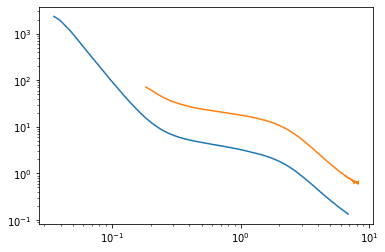

In [13]:
fig, ax = plt.subplots()
ax.plot(ref0_q, ref0_I)
ax.plot(ref_q, ref_I*calibrationFactor)
ax.loglog()

In [14]:
# find integration limits for the Reference data
q_Limit_min = np.array((ref0_q.min(),ref_q.min())).max()
q_Limit_max = np.array((ref0_q.max(),ref_q.max())).min()
q_normLimit_min = 2 * q_Limit_min
q_normLimit_max = q_Limit_max - 0.8*q_Limit_max
# find the index close to the limit
ref0_IndexMin = min(range(ref0_q.size), key=lambda i: abs(ref0_q[i]-q_normLimit_min))
ref0_IndexMax = min(range(ref0_q.size), key=lambda i: abs(ref0_q[i]-q_normLimit_max))
ref_IndexMin = min(range(ref_q.size), key=lambda i: abs(ref_q[i]-q_normLimit_min))
ref_IndexMax = min(range(ref_q.size), key=lambda i: abs(ref_q[i]-q_normLimit_max))

print('Normalization between:',q_normLimit_min,'nm^-1 and ',q_normLimit_max,'nm^-1')
print('Index for Reference file:',ref0_IndexMin,'with',ref0_q[ref0_IndexMin],'nm^-1 to',ref0_IndexMax,'with',ref0_q[ref0_IndexMax],'nm^-1')
print('Index for Experimental data:',ref_IndexMin,'with',ref_q[ref_IndexMin],'nm^-1 to',ref_IndexMax,'with',ref_q[ref_IndexMax],'nm^-1')

Normalization between: 0.3683394534903624 nm^-1 and  1.3693399999999993 nm^-1
Index for Reference file: 86 with 0.36699 nm^-1 to 271 with 1.3693 nm^-1
Index for Experimental data: 9 with 0.36544773030230315 nm^-1 to 59 with 1.372547750064092 nm^-1


In [16]:
type(q)

numpy.ndarray

In [52]:
tifNum

'0015'

In [17]:
metaFrame

,Time,VacSampleX,VacSampleY,Energy,Pilatus_Tiff,Pilatus_Trigger,Pilatus_filename,PilatusAcqTime,Keysight1,Keysight2,...,SampleName,SampleThickness,Empty_Index,Background_Index,Reference_Index,MaskFile,x_Center,y_Center,SampleToDet_Distance,Unnamed: 27
0,34.827,133.00,-1.100000e-05,7000.002692,378,379,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,600,2.299318e-06,5.430643e-10,...,Empty,1.000000,0,0,1,mask_short2.edf,456.736,556.579,0.80169,0
1,639.834,123.00,-4.000000e-06,7000.002692,379,380,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,300,2.152853e-06,5.432002e-10,...,GC,0.005400,0,0,1,mask_short2.edf,456.736,556.579,0.80169,0
2,944.835,113.00,4.163336e-17,7000.002692,380,381,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,10,1.337529e-06,5.675809e-10,...,AgBeh,0.020000,0,0,1,mask_short2.edf,456.736,556.579,0.80169,0
3,963.534,88.16,1.000000e-06,7000.002692,381,382,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,600,1.448823e-06,5.820030e-10,...,Empty Cap,0.106904,0,0,1,mask_short2.edf,456.736,556.579,0.80169,0
4,1567.693,83.10,4.163336e-17,7000.002692,382,383,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,600,9.860936e-07,5.657099e-10,...,Hexane Cap,0.096177,0,0,1,mask_short2.edf,456.736,556.579,0.80169,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,5776.361,23.00,9.999880e-01,9999.991504,517,518,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,300,4.484193e-07,5.893668e-10,...,217,0.100000,126,142,127,mask_short2.edf,456.736,556.579,0.80169,16
140,6081.651,23.00,-9.149983e+00,9999.991504,518,519,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,300,4.445866e-07,6.032399e-10,...,195,0.100000,126,142,127,mask_short2.edf,456.736,556.579,0.80169,16
141,6390.580,13.00,7.799996e+00,9999.991504,519,520,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,600,4.389022e-07,6.102984e-10,...,232,0.100000,126,142,127,mask_short2.edf,456.736,556.579,0.80169,16
142,6994.894,13.00,5.880000e-04,9999.991504,520,521,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,600,4.517064e-07,5.958377e-10,...,empty Kapton Hexane,0.100000,126,126,127,mask_short2.edf,456.736,556.579,0.80169,0
